# System Threat Forecaster using ML Classification Approach

This notebook presents a complete implementation of a machine learning classification system that predicts whether a system is likely to be infected by malware based on various system properties. The code is organized in a modular way that allows selective training of different models and fine-tuning of specific parts of the pipeline.

## 0. Setting up the environment

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
import warnings
import os
import joblib
from datetime import datetime

# Set plot style and figure size for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
warnings.filterwarnings('ignore')

# Create a directory for model artifacts if it doesn't exist
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

## 1. Configuration and Settings

This section defines the configuration parameters that control the behavior of the pipeline.

In [15]:
# Define the configuration for controlling pipeline behavior
CONFIG = {
    # Path configuration
    'data_path': {
        'train': './kaggle/input/System-Threat-Forecaster/train.csv',
        'test': './kaggle/input/System-Threat-Forecaster/test.csv',
        'submission': 'submission.csv'
    },
    
    # Pipeline control flags
    'run_eda': True,                 # Run exploratory data analysis
    'handle_missing_values': True,   # Handle missing values in the dataset
    'feature_engineering': False,     # Perform feature engineering
    'feature_selection': False ,      # Apply feature selection methods
    'dimensionality_reduction': False, # Apply PCA for dimensionality reduction
    
    # Model selection flags (set the one you want to use for prediction to True)
    'models_to_train': {
        'decision_tree': True,
        'random_forest': True,
        'lightgbm': True,            # Our best performing model
        'naive_bayes': True,
        'logistic_regression': True,
        'ada_boost': True,
        'sgd': True
    },
    
    # Hyperparameter tuning settings
    'perform_hyperparameter_tuning': False,
    'cv_folds': 3,                   # Number of cross-validation folds
    
    # Random state for reproducibility
    'random_state': 42,
    
    # Missing value handling strategy
    'numeric_imputation_strategy': 'mean',
    'categorical_imputation_strategy': 'most_frequent',
    
    # Train-validation split ratio
    'test_size': 0.2,
}

## 2. Data Loading and Utilities

This section defines functions for loading data and other utility functions used across the pipeline.

In [16]:
def load_data(path=None):
    """
    Load the dataset from the specified path.
    
    Args:
        path (str): Path to the dataset.
        
    Returns:
        pd.DataFrame: Loaded dataset.
    """
    if path is None:
        path = CONFIG['data_path']['train']
    
    print(f"Loading data from {path}...")
    return pd.read_csv(path)

def save_model(model, model_name):
    """
    Save a trained model to disk.
    
    Args:
        model: Trained model object.
        model_name (str): Name of the model.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'models/{model_name}_{timestamp}.joblib'
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")
    return filename

def load_model(filename):
    """
    Load a model from disk.
    
    Args:
        filename (str): Path to the saved model.
        
    Returns:
        Trained model object.
    """
    return joblib.load(filename)

def log_result(model_name, metrics, hyperparams=None):
    """
    Log model results for later comparison.
    
    Args:
        model_name (str): Name of the model.
        metrics (dict): Dictionary of performance metrics.
        hyperparams (dict, optional): Model hyperparameters.
    """
    results = {
        'model_name': model_name,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        **metrics
    }
    
    if hyperparams:
        results['hyperparams'] = hyperparams
    
    # Convert to DataFrame for easier reading
    results_df = pd.DataFrame([results])
    
    # Create or append to results file
    results_file = 'results/model_comparison.csv'
    if os.path.exists(results_file):
        existing_results = pd.read_csv(results_file)
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
        updated_results.to_csv(results_file, index=False)
    else:
        results_df.to_csv(results_file, index=False)
    
    print(f"Results logged to {results_file}")

## 3. Exploratory Data Analysis

This section defines functions for exploring and visualizing the dataset.

In [17]:
def perform_eda(data):
    """
    Perform exploratory data analysis on the dataset.
    
    Args:
        data (pd.DataFrame): Input dataset.
    """
    if not CONFIG['run_eda']:
        print("Skipping EDA as per configuration.")
        return
    
    print("\n=== Exploratory Data Analysis ===")
    
    # Dataset information
    print(f"Dataset shape: {data.shape}")
    print("\nMissing values:")
    missing_vals = data.isnull().sum()
    print(missing_vals[missing_vals > 0])
    
    # Check target distribution
    if 'target' in data.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(x='target', data=data)
        plt.title('Distribution of Target Variable')
        plt.xlabel('Target (0: No Malware, 1: Malware Detected)')
        plt.show()
        
        # Target distribution percentages
        target_counts = data['target'].value_counts(normalize=True) * 100
        print("\nTarget distribution percentages:")
        for target, percentage in target_counts.items():
            print(f"Target {target}: {percentage:.2f}%")
    
    # Identify numerical and categorical columns
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = data.select_dtypes(include=['object']).columns
    
    print(f"\nNumber of numerical features: {len(numeric_cols)}")
    print(f"Number of categorical features: {len(categorical_cols)}")
    
    # Display statistical summary
    print("\nStatistical summary of numerical features:")
    print(data.describe())
    
    # Display information about categorical features
    if len(categorical_cols) > 0:
        print("\nCategorical feature information:")
        for col in categorical_cols[:5]:  # Show info for first 5 categorical columns
            print(f"\n{col}:")
            print(data[col].value_counts().head(5))
    
    # Correlation analysis of numerical features
    plt.figure(figsize=(12, 10))
    corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()
    
    # If target column exists, show top correlated features with target
    if 'target' in corr_matrix.columns:
        target_corr = corr_matrix['target'].sort_values(ascending=False)
        print("\nTop 10 features correlated with target:")
        print(target_corr.head(11))  # 11 because the target itself will be at the top
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=target_corr.head(11).index, y=target_corr.head(11).values)
        plt.title('Features with Highest Correlation to Target')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

## 4. Data Preprocessing

This section defines functions for preprocessing the data, including handling missing values and encoding categorical features.

In [18]:
def preprocess_data(data, is_training=True, target_col='target', preprocessors=None):
    """
    Preprocess the data for model training or prediction.
    
    Args:
        data (pd.DataFrame): Input dataset.
        is_training (bool): Whether this is the training data.
        target_col (str): Name of the target column.
        preprocessors (dict, optional): Dictionary of preprocessors from training data.
        
    Returns:
        tuple: X, y (if is_training=True), or X (if is_training=False), and preprocessors
    """
    # Make a copy to avoid modifying the original data
    df = data.copy()
    
    # Separate features and target if this is training data
    if is_training and target_col in df.columns:
        y = df[target_col]
        X = df.drop(columns=[target_col])
    else:
        y = None
        X = df
    
    # Identify numerical and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    print(f"Found {len(numeric_cols)} numerical columns and {len(categorical_cols)} categorical columns")
    
    # Initialize or use provided preprocessors
    if preprocessors is None:
        preprocessors = {}
        
        # Create preprocessors for numerical and categorical features
        if CONFIG['handle_missing_values']:
            print("Creating new preprocessors...")
            # For numerical columns
            num_imputer = SimpleImputer(strategy=CONFIG['numeric_imputation_strategy'])
            preprocessors['num_imputer'] = num_imputer
            
            # For categorical columns
            cat_imputer = SimpleImputer(strategy=CONFIG['categorical_imputation_strategy'])
            preprocessors['cat_imputer'] = cat_imputer
            
            # Scaler for numerical features
            scaler = StandardScaler()
            preprocessors['scaler'] = scaler
            
            # Label encoders for categorical features
            label_encoders = {}
            for col in categorical_cols:
                le = LabelEncoder()
                label_encoders[col] = le
            preprocessors['label_encoders'] = label_encoders
    
    # Apply the preprocessors
    if CONFIG['handle_missing_values']:
        # Handle missing values in numerical columns
        if len(numeric_cols) > 0:
            if is_training:
                X[numeric_cols] = preprocessors['num_imputer'].fit_transform(X[numeric_cols])
            else:
                X[numeric_cols] = preprocessors['num_imputer'].transform(X[numeric_cols])
        
        # Handle missing values in categorical columns
        if len(categorical_cols) > 0:
            for col in categorical_cols:
                # Handle missing values
                if is_training:
                    X[col] = preprocessors['cat_imputer'].fit_transform(X[col].values.reshape(-1, 1)).flatten()
                else:
                    X[col] = preprocessors['cat_imputer'].transform(X[col].values.reshape(-1, 1)).flatten()
                
                # Encode categorical features
                if is_training:
                    X[col] = preprocessors['label_encoders'][col].fit_transform(X[col].astype(str))
                else:
                    # Handle unknown categories in test data
                    known_categories = set(preprocessors['label_encoders'][col].classes_)
                    unknown_mask = ~X[col].astype(str).isin(known_categories)
                    if unknown_mask.any():
                        most_frequent = preprocessors['label_encoders'][col].classes_[0]
                        X.loc[unknown_mask, col] = most_frequent
                    # Transform
                    X[col] = preprocessors['label_encoders'][col].transform(X[col].astype(str))
        
        # Scale numerical features
        if len(numeric_cols) > 0:
            if is_training:
                scaled_features = preprocessors['scaler'].fit_transform(X[numeric_cols])
            else:
                scaled_features = preprocessors['scaler'].transform(X[numeric_cols])
            # Convert back to DataFrame to preserve column names
            X[numeric_cols] = pd.DataFrame(scaled_features, columns=numeric_cols, index=X.index)
    
    if is_training:
        return X, y, preprocessors
    else:
        return X, preprocessors

def split_data(X, y):
    """
    Split data into training and validation sets.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        
    Returns:
        tuple: X_train, X_val, y_train, y_val
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=CONFIG['test_size'], 
        random_state=CONFIG['random_state'],
        stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    
    return X_train, X_val, y_train, y_val

## 5. Feature Engineering and Selection

This section defines functions for feature engineering and selection.

In [19]:
def engineer_features(X_train, X_val=None, X_test=None, y_train=None):
    """
    Perform feature engineering on the data.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix.
        X_val (pd.DataFrame, optional): Validation feature matrix.
        X_test (pd.DataFrame, optional): Test feature matrix.
        
    Returns:
        tuple: Transformed X_train, X_val, X_test
    """
    if not CONFIG['feature_engineering']:
        print("Skipping feature engineering as per configuration.")
        return X_train, X_val, X_test
    
    print("\n=== Feature Engineering ===")
    
    # Get numeric columns from train data
    train_numeric_cols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
    print(f"\nFound {len(train_numeric_cols)} numeric columns in train data")
    
    # Keep original columns and add interaction features
    interaction_cols = []
    top_cols = []
    
    if len(train_numeric_cols) >= 2 and y_train is not None:
        # Calculate correlations with target
        correlations = []
        for col in train_numeric_cols:
            corr = abs(X_train[col].corr(y_train))
            correlations.append((col, corr))
        
        # Sort by correlation and take top 3
        correlations.sort(key=lambda x: x[1], reverse=True)
        top_cols = [col for col, _ in correlations[:3]]
        print(f"Using top correlated columns for interactions: {top_cols}")
        
        # Create interactions for top correlated columns if we have any
        if len(top_cols) >= 2:
            for i, col1 in enumerate(top_cols[:-1]):
                for col2 in top_cols[i+1:]:
                    interaction_name = f"{col1}_x_{col2}"
                    interaction_cols.append(interaction_name)
                    
                    # Create interaction features
                    X_train[interaction_name] = X_train[col1].multiply(X_train[col2])
                    if X_val is not None and col1 in X_val.columns and col2 in X_val.columns:
                        X_val[interaction_name] = X_val[col1].multiply(X_val[col2])
                    if X_test is not None and col1 in X_test.columns and col2 in X_test.columns:
                        X_test[interaction_name] = X_test[col1].multiply(X_test[col2])
    else:
        print("Not enough numeric columns or no target variable for correlation-based selection")
    
    print(f"Total features after engineering: {X_train.shape[1]}")
    
    # Return the transformed datasets
    return X_train, X_val, X_test
    
    return X_train, X_val, X_test

def select_features(X_train, y_train, X_val=None, X_test=None):
    """
    Perform feature selection on the data.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix.
        y_train (pd.Series): Training target variable.
        X_val (pd.DataFrame, optional): Validation feature matrix.
        X_test (pd.DataFrame, optional): Test feature matrix.
        
    Returns:
        tuple: Transformed X_train, X_val, X_test
    """
    if not CONFIG['feature_selection']:
        print("Skipping feature selection as per configuration.")
        return X_train, X_val, X_test
    
    print("\n=== Feature Selection ===")
    
    # Print column names before feature selection
    print(f"\nColumns in X_train before selection: {X_train.columns.tolist()}")
    if X_test is not None:
        print(f"Columns in X_test before selection: {X_test.columns.tolist()}")
    
    # Use SelectKBest with f_classif for feature selection
    k = min(30, X_train.shape[1])  # Select top k features or all if less than k
    selector = SelectKBest(score_func=f_classif, k=k)
    
    # Ensure all datasets have the same columns as X_train
    all_columns = X_train.columns.tolist()
    
    # Add missing columns to validation set
    if X_val is not None:
        for col in all_columns:
            if col not in X_val.columns:
                X_val[col] = 0
        X_val = X_val[all_columns]
    
    # Add missing columns to test set
    if X_test is not None:
        for col in all_columns:
            if col not in X_test.columns:
                X_test[col] = 0
        X_test = X_test[all_columns]
    
    # Fit and transform training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    # Get selected feature indices and names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    print(f"Selected {len(selected_features)} features:")
    print(selected_features)
    
    # Transform all datasets
    X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    
    if X_val is not None:
        X_val_selected = selector.transform(X_val)
        X_val = pd.DataFrame(X_val_selected, columns=selected_features, index=X_val.index)
    
    if X_test is not None:
        X_test_selected = selector.transform(X_test)
        X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)
    
    return X_train, X_val, X_test

def apply_dimensionality_reduction(X_train, X_val=None, X_test=None, pca_model=None):
    """
    Apply dimensionality reduction to the data.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix.
        X_val (pd.DataFrame, optional): Validation feature matrix.
        X_test (pd.DataFrame, optional): Test feature matrix.
        pca_model (PCA, optional): Existing PCA model to use for transformation.
        
    Returns:
        tuple: Transformed X_train, X_val, X_test, and the PCA object
    """
    if not CONFIG['dimensionality_reduction']:
        print("Skipping dimensionality reduction as per configuration.")
        return X_train, X_val, X_test, None
    
    print("\n=== Dimensionality Reduction (PCA) ===")
    
    # Apply PCA to reduce dimensions
    if pca_model is None:
        # Create a new PCA model if not provided
        pca = PCA(n_components=0.95)
        X_train_pca = pca.fit_transform(X_train)
        print(f"Reduced dimensions from {X_train.shape[1]} to {pca.n_components_}")
        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    else:
        # Use the provided PCA model
        pca = pca_model
        X_train_pca = pca.transform(X_train)
    
    # Transform validation and test data if provided
    if X_val is not None:
        X_val_pca = pca.transform(X_val)
        X_val = pd.DataFrame(X_val_pca)
    
    if X_test is not None:
        X_test_pca = pca.transform(X_test)
        X_test = pd.DataFrame(X_test_pca)
    
    # Convert X_train to DataFrame
    X_train = pd.DataFrame(X_train_pca)
    
    return X_train, X_val, X_test, pca

## 6. Model Training

This section defines functions for training different models.

In [20]:
def get_model_hyperparameters(model_name):
    """
    Get hyperparameters for a specific model for tuning.
    
    Args:
        model_name (str): Name of the model.
        
    Returns:
        dict: Hyperparameters for grid search or random search.
    """
    hyperparams = {
        'decision_tree': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'class_weight': ['balanced', None]
        },
        'random_forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5]
        },
        'lightgbm': {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_child_samples': [10, 20, 30],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': np.linspace(0, 1, 5),
            'reg_lambda': np.linspace(0, 1, 5)
        },
        'naive_bayes': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        },
        'logistic_regression': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'solver': ['liblinear', 'saga'],
            'max_iter': [1000],
            'class_weight': ['balanced', None]
        },
        'ada_boost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0],
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'sgd': {
            'loss': ['hinge', 'log_loss', 'modified_huber'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'alpha': [0.0001, 0.001, 0.01],
            'max_iter': [1000],
            'class_weight': ['balanced', None]
        }
    }
    
    return hyperparams.get(model_name, {})

def get_default_model_params(model_name):
    """
    Get default parameters for a specific model.
    
    Args:
        model_name (str): Name of the model.
        
    Returns:
        dict: Default parameters for the model.
    """
    default_params = {
        'decision_tree': {
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'class_weight': 'balanced',
            'random_state': CONFIG['random_state']
        },
        'random_forest': {
            'n_estimators': 100,
            'max_depth': 20,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'class_weight': 'balanced',
            'random_state': CONFIG['random_state']
        },
        'lightgbm': {
            'n_estimators': 200,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_child_samples': 10,
            'subsample': 0.6,
            'colsample_bytree': 1.0,
            'reg_alpha': 1.0,
            'reg_lambda': 0.75,
            'random_state': CONFIG['random_state']
        },
        'naive_bayes': {
            'var_smoothing': 1e-09
        },
        'logistic_regression': {
            'C': 1.0,
            'solver': 'liblinear',
            'max_iter': 1000,
            'class_weight': 'balanced',
            'random_state': CONFIG['random_state']
        },
        'ada_boost': {
            'n_estimators': 200,
            'learning_rate': 1.0,
            'random_state': CONFIG['random_state']
        },
        'sgd': {
            'loss': 'log_loss',
            'penalty': 'elasticnet',
            'alpha': 0.001,
            'max_iter': 1000,
            'class_weight': None,
            'random_state': CONFIG['random_state']
        }
    }
    
    return default_params.get(model_name, {})

def get_model(model_name, params=None):
    """
    Get a model instance with specified parameters.
    
    Args:
        model_name (str): Name of the model.
        params (dict, optional): Model parameters. If None, use default parameters.
        
    Returns:
        Model instance.
    """
    if params is None:
        params = get_default_model_params(model_name)
    
    if model_name == 'decision_tree':
        return DecisionTreeClassifier(**params)
    elif model_name == 'random_forest':
        return RandomForestClassifier(**params)
    elif model_name == 'lightgbm':
        return LGBMClassifier(**params)
    elif model_name == 'naive_bayes':
        return GaussianNB(**params)
    elif model_name == 'logistic_regression':
        return LogisticRegression(**params)
    elif model_name == 'ada_boost':
        return AdaBoostClassifier(**params)
    elif model_name == 'sgd':
        return SGDClassifier(**params)
    else:
        raise ValueError(f"Unknown model: {model_name}")


def tune_hyperparameters(model_name, X_train, y_train):
    """
    Tune hyperparameters for a specific model.
    
    Args:
        model_name (str): Name of the model.
        X_train (pd.DataFrame): Training feature matrix.
        y_train (pd.Series): Training target variable.
        
    Returns:
        dict: Best hyperparameters.
    """
    if not CONFIG['perform_hyperparameter_tuning']:
        print(f"Skipping hyperparameter tuning for {model_name} as per configuration.")
        return get_default_model_params(model_name)
    
    print(f"\n=== Hyperparameter Tuning for {model_name} ===")
    
    # Get base model and hyperparameters to tune
    base_model = get_model(model_name)
    hyperparams = get_model_hyperparameters(model_name)
    
    # Use RandomizedSearchCV for efficient tuning
    search = RandomizedSearchCV(
        base_model,
        hyperparams,
        n_iter=10,  # Number of parameter settings sampled
        cv=CONFIG['cv_folds'],
        scoring='accuracy',
        random_state=CONFIG['random_state'],
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")
    
    return search.best_params_

def train_model(model_name, X_train, y_train, X_val=None, y_val=None):
    """
    Train a model on the given data.
    
    Args:
        model_name (str): Name of the model.
        X_train (pd.DataFrame): Training feature matrix.
        y_train (pd.Series): Training target variable.
        X_val (pd.DataFrame, optional): Validation feature matrix.
        y_val (pd.Series, optional): Validation target variable.
        
    Returns:
        tuple: Trained model and performance metrics.
    """
    print(f"\n=== Training {model_name} ===")
    
    # Tune hyperparameters if required
    if CONFIG['perform_hyperparameter_tuning']:
        params = tune_hyperparameters(model_name, X_train, y_train)
    else:
        params = get_default_model_params(model_name)
    
    # Get and train the model
    model = get_model(model_name, params)
    model.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    print(f"Training accuracy: {train_accuracy:.4f}")
    
    # Evaluate on validation data if provided
    metrics = {'train_accuracy': train_accuracy}
    
    if X_val is not None and y_val is not None:
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        print(f"Validation accuracy: {val_accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_val_pred))
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {model_name.replace("_", " ").title()}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
        metrics.update({
            'val_accuracy': val_accuracy,
            'val_report': classification_report(y_val, y_val_pred, output_dict=True)
        })
    
    # Save the model and log results
    model_path = save_model(model, model_name)
    log_result(model_name, metrics, params)
    
    return model, metrics

def train_all_selected_models(X_train, y_train, X_val, y_val):
    """
    Train all selected models and return the best one.
    
    Args:
        X_train (pd.DataFrame): Training feature matrix.
        y_train (pd.Series): Training target variable.
        X_val (pd.DataFrame): Validation feature matrix.
        y_val (pd.Series): Validation target variable.
        
    Returns:
        tuple: Best model name, best model, and performance metrics.
    """
    models_to_train = [model for model, train in CONFIG['models_to_train'].items() if train]
    
    if not models_to_train:
        print("No models selected for training. Please update the configuration.")
        return None, None, None
    
    print(f"\n=== Training {len(models_to_train)} models: {models_to_train} ===")
    
    trained_models = {}
    best_model_name = None
    best_model = None
    best_val_accuracy = 0
    
    for model_name in models_to_train:
        model, metrics = train_model(model_name, X_train, y_train, X_val, y_val)
        trained_models[model_name] = (model, metrics)
        
        # Check if this model is better than the current best
        if 'val_accuracy' in metrics and metrics['val_accuracy'] > best_val_accuracy:
            best_val_accuracy = metrics['val_accuracy']
            best_model_name = model_name
            best_model = model
    
    if best_model is not None:
        print(f"\nBest model: {best_model_name} with validation accuracy: {best_val_accuracy:.4f}")
    
    return best_model_name, best_model, trained_models

## 7. Model Evaluation and Comparison

This section defines functions for evaluating and comparing different models.

In [21]:
def evaluate_model(model, X, y, model_name='Model'):
    """
    Evaluate a model on the given data.
    
    Args:
        model: Trained model.
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        model_name (str): Name of the model for display.
        
    Returns:
        dict: Performance metrics.
    """
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred)
    
    # Display results
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Plot feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
        plt.title(f'Top 15 Feature Importances - {model_name}')
        plt.tight_layout()
        plt.show()
    
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }

def compare_models(trained_models, X_val, y_val):
    """
    Compare the performance of multiple trained models.
    
    Args:
        trained_models (dict): Dictionary of trained models and their metrics.
        X_val (pd.DataFrame): Validation feature matrix.
        y_val (pd.Series): Validation target variable.
    """
    if not trained_models:
        print("No trained models to compare.")
        return
    
    print("\n=== Model Comparison ===")
    
    # Extract metrics for comparison
    comparison_data = []
    
    for model_name, (model, metrics) in trained_models.items():
        # Ensure we have validation metrics
        if 'val_accuracy' not in metrics:
            # Evaluate the model if validation metrics are missing
            val_metrics = evaluate_model(model, X_val, y_val, model_name)
            metrics['val_accuracy'] = val_metrics['accuracy']
            metrics['val_report'] = val_metrics['report']
        
        # Extract key metrics for comparison
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['val_accuracy'],
            'Precision (weighted)': metrics['val_report']['weighted avg']['precision'],
            'Recall (weighted)': metrics['val_report']['weighted avg']['recall'],
            'F1 Score (weighted)': metrics['val_report']['weighted avg']['f1-score']
        })
    
    # Convert to DataFrame for display
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
    
    print(comparison_df)
    
    # Visualize comparison
    plt.figure(figsize=(12, 8))
    metrics_to_plot = ['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1 Score (weighted)']
    
    # Reshape data for plotting
    plot_data = pd.melt(comparison_df, 
                        id_vars=['Model'], 
                        value_vars=metrics_to_plot,
                        var_name='Metric', 
                        value_name='Score')
    
    # Plot
    sns.barplot(x='Model', y='Score', hue='Metric', data=plot_data)
    plt.title('Model Performance Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 8. Prediction and Submission Generation

This section defines functions for making predictions on test data and generating submission files.

In [22]:
def predict_and_generate_submission(model, X_test, output_path=None):
    """
    Make predictions on test data and generate a submission file.
    
    Args:
        model: Trained model.
        X_test (pd.DataFrame): Test feature matrix.
        output_path (str, optional): Path to save the submission file.
        
    Returns:
        pd.DataFrame: Submission DataFrame.
    """
    if output_path is None:
        output_path = CONFIG['data_path']['submission']
    
    print(f"\n=== Generating Submission ===")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'id': range(len(y_pred)),
        'target': y_pred
    })
    
    # Save to CSV
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")
    
    return submission

## 9. Main Pipeline

This section defines the main pipeline that orchestrates the entire workflow.

In [23]:
def run_pipeline():
    """
    Run the complete machine learning pipeline.
    """
    print("=== Starting System Threat Forecaster Pipeline ===\n")
    
    # Step 1: Load data
    train_data = load_data(CONFIG['data_path']['train'])
    test_data = load_data(CONFIG['data_path']['test'])
    
    # Step 2: Exploratory Data Analysis
    perform_eda(train_data)
    
    # Step 3: Preprocess data
    X, y, preprocessors = preprocess_data(train_data)
    X_test, _ = preprocess_data(test_data, is_training=False, preprocessors=preprocessors)
    
    # Step 4: Split data into train and validation sets
    X_train, X_val, y_train, y_val = split_data(X, y)
    
    # Step 5: Feature engineering on all datasets
    X_train, X_val, X_test = engineer_features(X_train, X_val, X_test, y_train=y_train)
    
    # Step 6: Feature selection on all datasets
    X_train, X_val, X_test = select_features(X_train, y_train, X_val, X_test)
    
    # Step 7: Dimensionality reduction on all datasets
    X_train, X_val, X_test, pca = apply_dimensionality_reduction(X_train, X_val, X_test)
    
    # Step 8: Train models
    best_model_name, best_model, trained_models = train_all_selected_models(X_train, y_train, X_val, y_val)
    
    # Step 9: Compare models
    if trained_models and len(trained_models) > 1:
        compare_models(trained_models, X_val, y_val)
    
    # Step 10: Generate submission with the best model
    if best_model is not None:
        submission = predict_and_generate_submission(best_model, X_test)
    else:
        print("No best model found. Cannot generate submission.")
    
    print("=== Pipeline Completed ===\n")
    
    return train_data, X_train, y_train, X_val, y_val, best_model_name, best_model, trained_models

## 10. Individual Model Training and Prediction Functions

These functions allow you to train specific models individually.

In [24]:
def train_decision_tree(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate a Decision Tree model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('decision_tree', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def train_random_forest(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate a Random Forest model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('random_forest', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def train_lightgbm(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate a LightGBM model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('lightgbm', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def train_naive_bayes(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate a Naive Bayes model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('naive_bayes', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def train_logistic_regression(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate a Logistic Regression model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('logistic_regression', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def train_ada_boost(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate an AdaBoost model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('ada_boost', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def train_sgd(X_train, y_train, X_val, y_val, tune_hyperparams=False):
    """Train and evaluate an SGD model."""
    if tune_hyperparams:
        CONFIG['perform_hyperparameter_tuning'] = True
    
    model, metrics = train_model('sgd', X_train, y_train, X_val, y_val)
    
    # Reset the hyperparameter tuning flag
    CONFIG['perform_hyperparameter_tuning'] = False
    
    return model, metrics

def make_prediction_with_model(model, test_data_path=None, preprocessors=None):
    """
    Make predictions using the specified model.
    
    Args:
        model: Trained model.
        test_data_path (str, optional): Path to test data.
        preprocessors (dict, optional): Preprocessors to use.
        
    Returns:
        pd.DataFrame: Submission DataFrame.
    """
    if test_data_path is None:
        test_data_path = CONFIG['data_path']['test']
    
    # Load test data
    test_data = load_data(test_data_path)
    
    # Preprocess test data
    X_test, _ = preprocess_data(test_data, is_training=False, preprocessors=preprocessors)
    
    # Generate submission
    return predict_and_generate_submission(model, X_test)

## 11. Example Usage

This section demonstrates how to use the pipeline.

In [25]:
def run_example():
    """Run an example of the pipeline."""
    # Load data
    train_data = load_data(CONFIG['data_path']['train'])
    
    # Preprocess data
    X, y, preprocessors = preprocess_data(train_data)
    
    # Split data
    X_train, X_val, y_train, y_val = split_data(X, y)
    
    # Train a LightGBM model
    CONFIG['models_to_train'] = {'lightgbm': True}
    best_model_name, best_model, trained_models = train_all_selected_models(X_train, y_train, X_val, y_val)
    
    # Load test data and make predictions
    test_data = load_data(CONFIG['data_path']['test'])
    X_test, _ = preprocess_data(test_data, is_training=False, preprocessors=preprocessors)
    
    # Generate submission with the best model
    if best_model is not None:
        submission = predict_and_generate_submission(best_model, X_test)
    else:
        print("No best model found. Cannot generate submission.")
    
    return best_model, preprocessors

## 12. Main Execution

Run this cell to execute the pipeline according to the configuration.

=== Starting System Threat Forecaster Pipeline ===

Loading data from ./kaggle/input/System-Threat-Forecaster/train.csv...
Loading data from ./kaggle/input/System-Threat-Forecaster/test.csv...

=== Exploratory Data Analysis ===
Dataset shape: (100000, 76)

Missing values:
RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeC

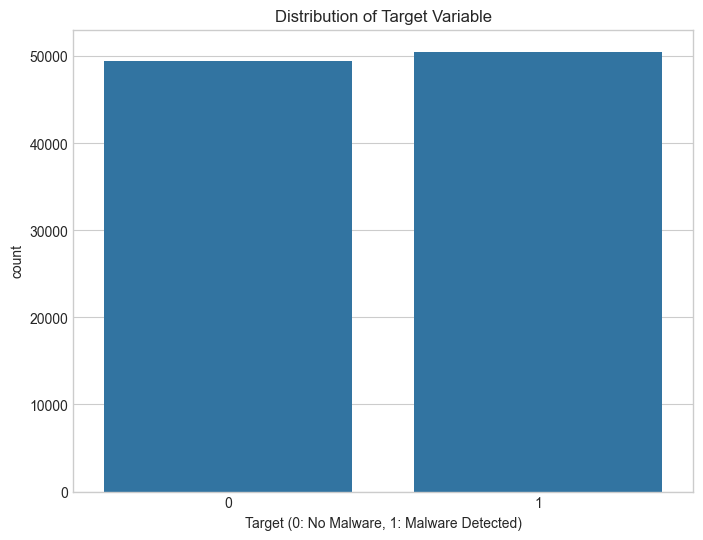


Target distribution percentages:
Target 1: 50.52%
Target 0: 49.48%

Number of numerical features: 48
Number of categorical features: 28

Statistical summary of numerical features:
       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533     

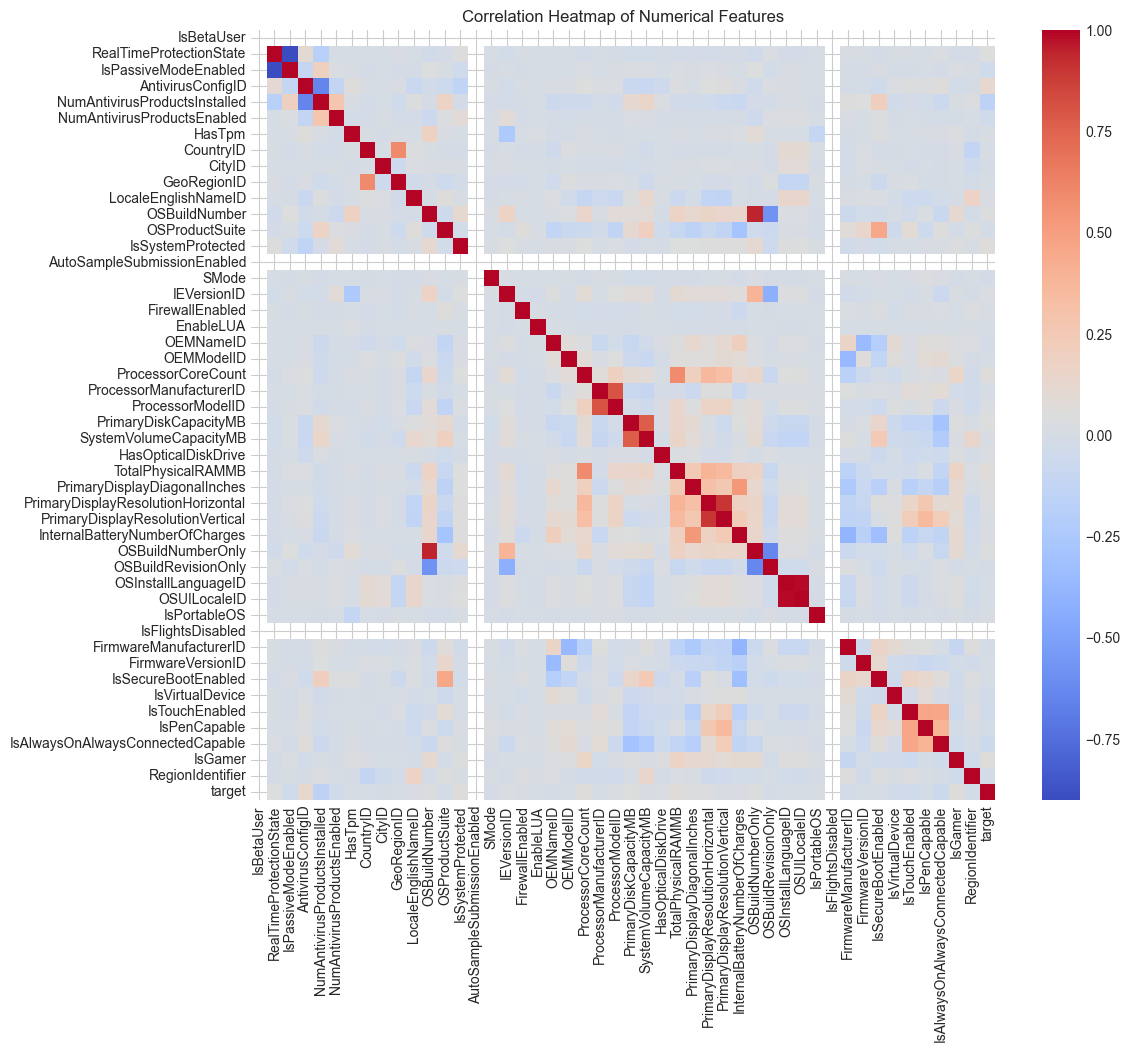


Top 10 features correlated with target:
target                          1.000000
AntivirusConfigID               0.118304
TotalPhysicalRAMMB              0.065747
IsSystemProtected               0.062401
IsGamer                         0.061191
ProcessorCoreCount              0.056769
PrimaryDiskCapacityMB           0.049117
RealTimeProtectionState         0.049012
OSBuildNumberOnly               0.038544
PrimaryDisplayDiagonalInches    0.035064
OSBuildNumber                   0.034712
Name: target, dtype: float64


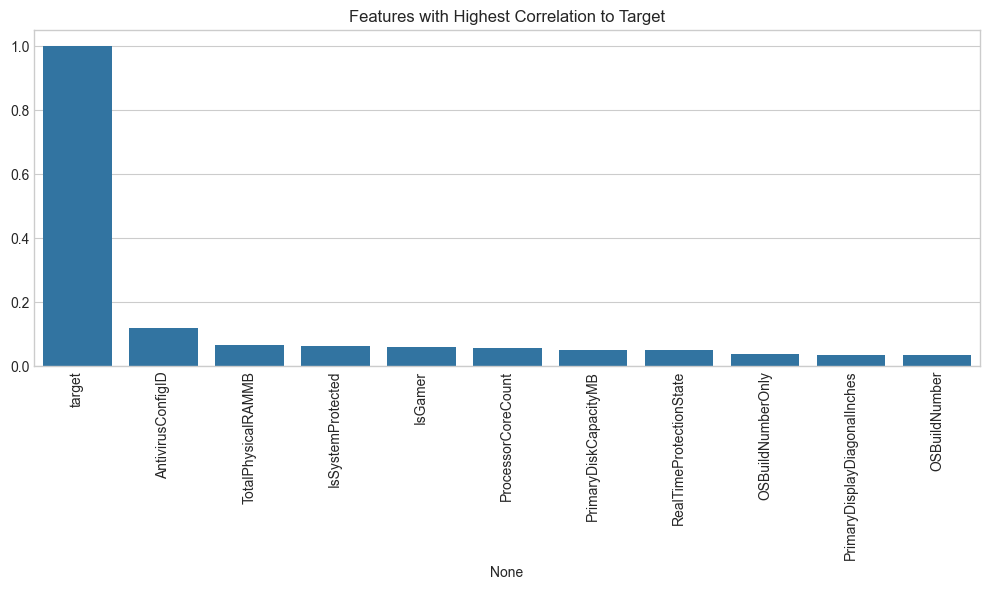

Found 47 numerical columns and 28 categorical columns
Creating new preprocessors...
Found 47 numerical columns and 28 categorical columns
Training set shape: (80000, 75)
Validation set shape: (20000, 75)
Skipping feature engineering as per configuration.
Skipping feature selection as per configuration.
Skipping dimensionality reduction as per configuration.

=== Training 7 models: ['decision_tree', 'random_forest', 'lightgbm', 'naive_bayes', 'logistic_regression', 'ada_boost', 'sgd'] ===

=== Training decision_tree ===
Training accuracy: 0.6351
Validation accuracy: 0.6016

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.57      9895
           1       0.59      0.68      0.63     10105

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



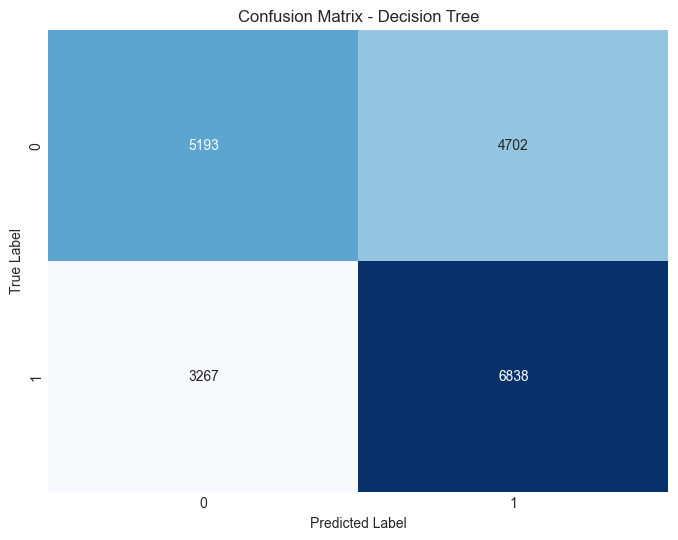

Model saved to models/decision_tree_20250323_152607.joblib
Results logged to results/model_comparison.csv

=== Training random_forest ===
Training accuracy: 0.9249
Validation accuracy: 0.6195

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      9895
           1       0.61      0.68      0.64     10105

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



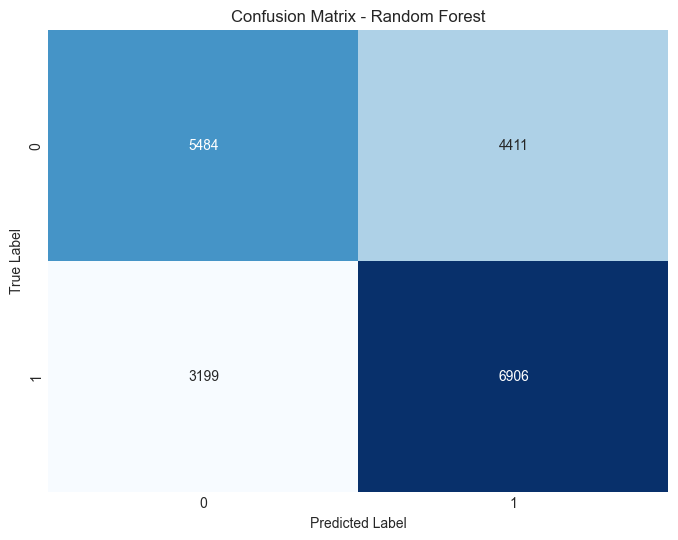

Model saved to models/random_forest_20250323_152618.joblib
Results logged to results/model_comparison.csv

=== Training lightgbm ===
[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5041
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

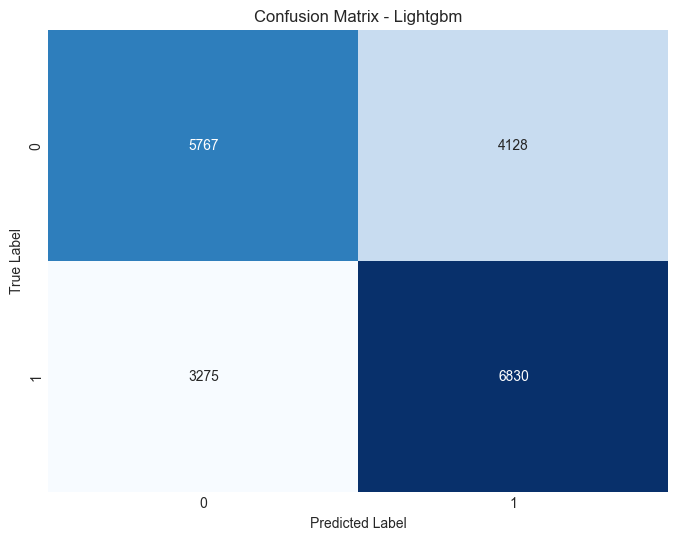

Model saved to models/lightgbm_20250323_152619.joblib
Results logged to results/model_comparison.csv

=== Training naive_bayes ===
Training accuracy: 0.5536
Validation accuracy: 0.5506

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.23      0.34      9895
           1       0.53      0.87      0.66     10105

    accuracy                           0.55     20000
   macro avg       0.58      0.55      0.50     20000
weighted avg       0.58      0.55      0.50     20000



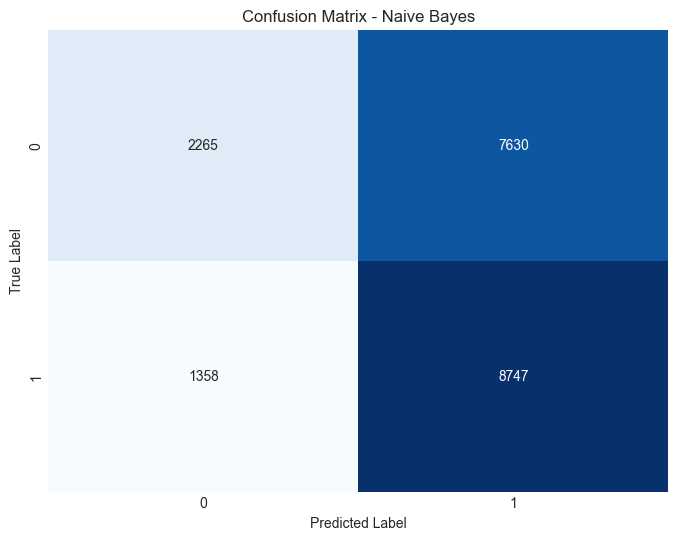

Model saved to models/naive_bayes_20250323_152620.joblib
Results logged to results/model_comparison.csv

=== Training logistic_regression ===
Training accuracy: 0.5971
Validation accuracy: 0.6009

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.57      9895
           1       0.59      0.67      0.63     10105

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



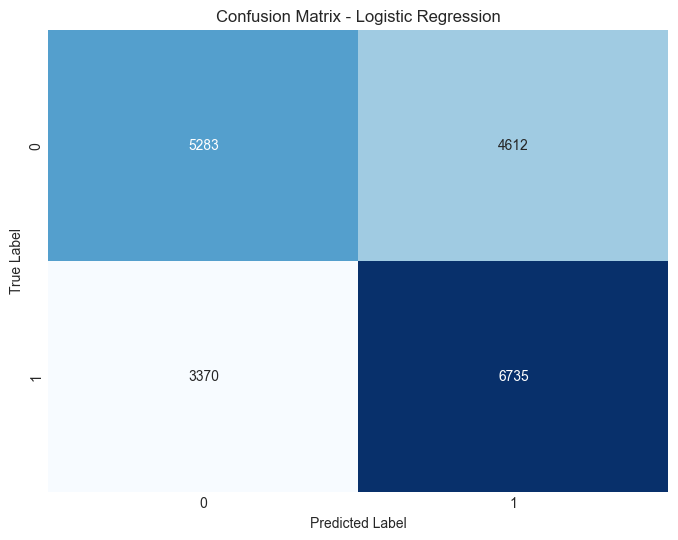

Model saved to models/logistic_regression_20250323_152626.joblib
Results logged to results/model_comparison.csv

=== Training ada_boost ===
Training accuracy: 0.6111
Validation accuracy: 0.6126

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.54      0.58      9895
           1       0.60      0.69      0.64     10105

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



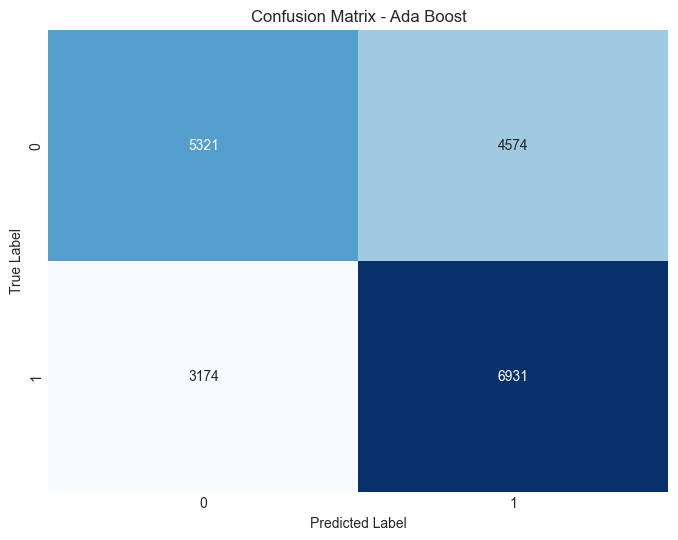

Model saved to models/ada_boost_20250323_152643.joblib
Results logged to results/model_comparison.csv

=== Training sgd ===
Training accuracy: 0.4948
Validation accuracy: 0.4947

Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      9895
           1       0.00      0.00      0.00     10105

    accuracy                           0.49     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.24      0.49      0.33     20000



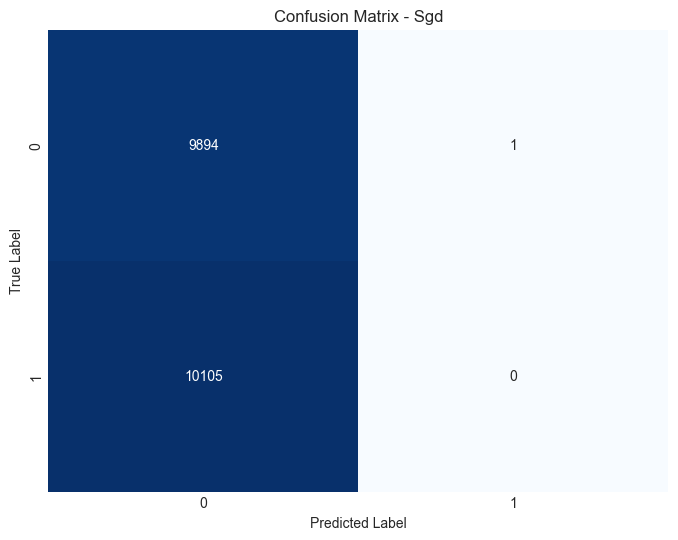

Model saved to models/sgd_20250323_152649.joblib
Results logged to results/model_comparison.csv

Best model: lightgbm with validation accuracy: 0.6299

=== Model Comparison ===
                 Model  Accuracy  Precision (weighted)  Recall (weighted)  \
0             lightgbm   0.62985              0.630469            0.62985   
1        random_forest   0.61950              0.620794            0.61950   
2            ada_boost   0.61260              0.614275            0.61260   
3        decision_tree   0.60155              0.603077            0.60155   
4  logistic_regression   0.60090              0.601955            0.60090   
5          naive_bayes   0.55060              0.579159            0.55060   
6                  sgd   0.49470              0.244765            0.49470   

   F1 Score (weighted)  
0             0.629009  
1             0.617852  
2             0.610403  
3             0.599183  
4             0.599091  
5             0.499563  
6             0.327494  


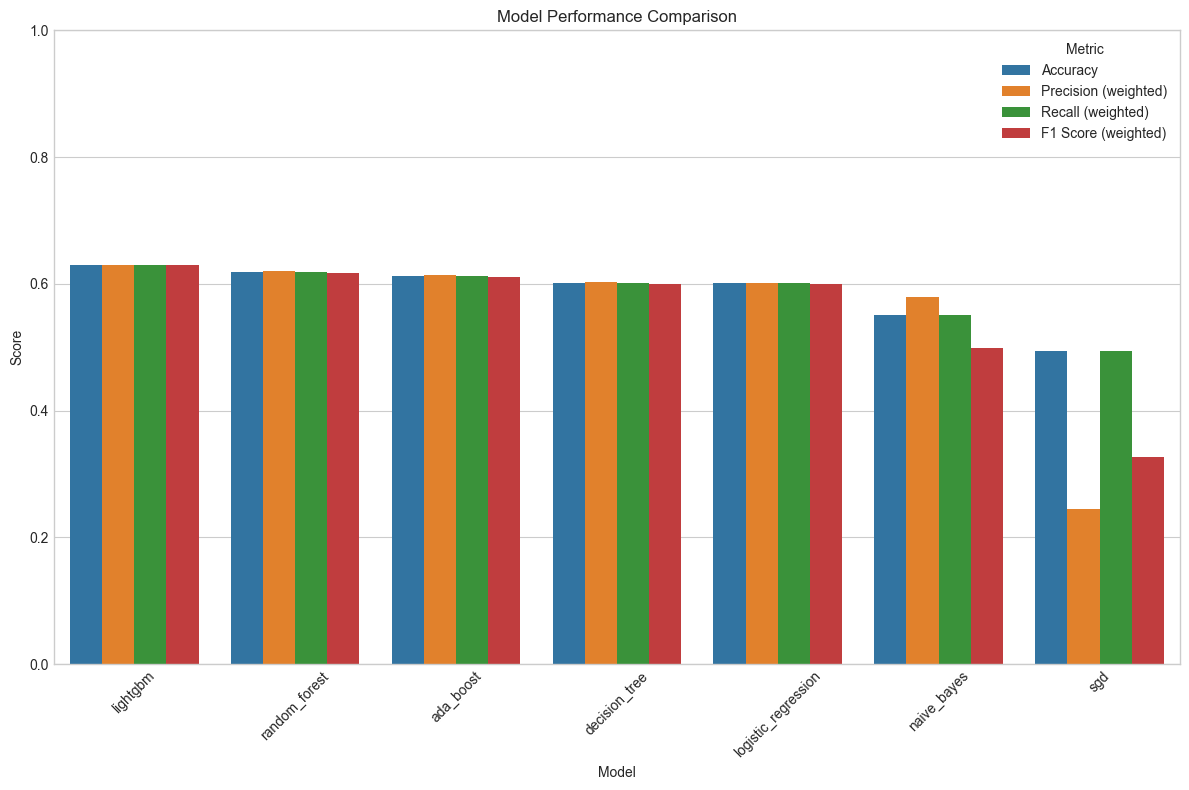


=== Generating Submission ===
Submission file saved to submission.csv
=== Pipeline Completed ===


=== Pipeline Summary ===
Best model: lightgbm


In [26]:
if __name__ == "__main__":
    # Run the complete pipeline
    train_data, X_train, y_train, X_val, y_val, best_model_name, best_model, trained_models = run_pipeline()
    
    # Print summary
    print("\n=== Pipeline Summary ===")
    print(f"Best model: {best_model_name}")